# Simulated_Echo_SVC
## Claude de Rijke-Thomas
### 15th March 2019

Open in tensorflowenv: source activate tensorflowenv

In [1]:
import scipy.io
import numpy as np
from scipy.integrate import simps, trapz
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop, adam
from sklearn.neural_network import MLPClassifier
from numba import jit, prange
import pickle

/anaconda3/envs/tensorflowenv/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Non Lead SVC

NLP1 corresponds to:
$$h\_s = [0, 0.05, 0.10, 0.15] $$
$$l\_surf = [0:1:10]; % large-scale correlation length (default = 5 m) $$
$$sigma\_si = [0.001:0.0005:0.004]; % sea ice rms height (default = 0.002 m) $$
$$sigma\_surf = [0:0.05:0.5]; % large-scale rms roughness height (default = 0.1 m)$$
NLP2 corresponds to:
$$h\_s =  [0.20, 0.25, 0.30, 0.35]$$
$$l\_surf = [0:1:10]; % large-scale correlation length (default = 5 m) $$
$$sigma\_si = [0.001:0.0005:0.004]; % sea ice rms height (default = 0.002 m) $$
$$sigma\_surf = [0:0.05:0.5]; % large-scale rms roughness height (default = 0.1 m)$$
NLP3 corresponds to:
$$h\_s =  [0.40, 0.45, 0.50]$$
$$l\_surf = [0:1:10]; % large-scale correlation length (default = 5 m) $$
$$sigma\_si = [0.001:0.0005:0.004]; % sea ice rms height (default = 0.002 m) $$
$$sigma\_surf = [0:0.05:0.5]; % large-scale rms roughness height (default = 0.1 m)$$

In [2]:
#Had to split the non-lead echo simulations into three parts for running on remote cluster: NLP1, NLP2 and NLP3
#(each took about 24 hours for non-lead, and 27 for lead on Myriad):
NLP1 = scipy.io.loadmat('/Users/claudederijkethomas/Desktop/Ice/Proj/FEM_Sim_NLP1.mat')
NLP2 = scipy.io.loadmat('/Users/claudederijkethomas/Desktop/Ice/Proj/FEM_Sim_NLP2.mat')
NLP3 = scipy.io.loadmat('/Users/claudederijkethomas/Desktop/Ice/Proj/FEM_Sim_NLP3.mat')

#added arrays containing values of the parameters iterated over (to be used as SVC labels):
sim_params = NLP1['parameters_lookup']
sim_params_2 = NLP2['parameters_lookup']
sim_params_3 = NLP3['parameters_lookup']

#simulated waveforms:
sim_echoes = NLP1['P_t_ml_range']
sim_echoes_2 = NLP2['P_t_ml_range']
sim_echoes_3 = NLP3['P_t_ml_range']


In [3]:
def extractNL():
    """extracting (and preprocessing) the simulated echo arrays into a format that can be understood by the SVC.
    (split into the three sections because I had to run three different scripts on Myriad to extract all the echoes).
    If you want to just train the SVC using snow depths from 0 to 15cm, comment out the 2nd and 3rd quadruple-loop 
    structures (as labelled)"""
    counter = 0
    data_arr = []
    label_arr = []
    int_label_arr = []
    #QUADRUPLE LOOP STRUCTURE 1
    for i in range(len(sim_echoes[:][:][:][:])): #snow depth{s} (h_s)
        for j in range(len(sim_echoes[0][:][:][:])): #l_surf{s}
            for k in range(len(sim_echoes[0][0][:][:])): #sigma_si{s}
                for l in range(len(sim_echoes[0][0][0][:])): #sigma_surf{s}
                    simulated_echo = [sim_echoes[i][j][k][l][m][0] for m in range(len(sim_echoes[i][j][k][l]))]
                    sim_echo_params = [sim_params[i][j][k][l][0][m] for m in range(len(sim_params[i][j][k][l][0]))]
                    #calculating the integral of the simulated echo:
                    simulated_echo_area = trapz(simulated_echo, dx = 1) 
                    #normalising the simulated echo:
                    norm_sim_echo = [x/simulated_echo_area for x in simulated_echo]
                    #
                    data_arr.append(norm_sim_echo)
                    label_arr.append(str(sim_echo_params))
                    int_label_arr.append(counter)
    #QUADRUPLE LOOP STRUCTURE 2
    for i in range(len(sim_echoes_2[:][:][:][:])): #snow depth{s} (h_s)
        for j in range(len(sim_echoes_2[0][:][:][:])): #l_surf{s}
            for k in range(len(sim_echoes_2[0][0][:][:])): #sigma_si{s}
                for l in range(len(sim_echoes_2[0][0][0][:])): #sigma_surf{s}
                    simulated_echo = [sim_echoes_2[i][j][k][l][m][0] for m in range(len(sim_echoes_2[i][j][k][l]))]
                    sim_echo_params = [sim_params_2[i][j][k][l][0][m] for m in range(len(sim_params_2[i][j][k][l][0]))]
                    simulated_echo_area = trapz(simulated_echo, dx = 1) 
                    norm_sim_echo = [x/simulated_echo_area for x in simulated_echo]
                    data_arr.append(norm_sim_echo)
                    label_arr.append(str(sim_echo_params))
                    int_label_arr.append(counter)
                    counter+=1
    #QUADRUPLE LOOP STRUCTURE 3
    for i in range(len(sim_echoes_3[:][:][:][:])): #snow depth{s} (h_s)
        for j in range(len(sim_echoes_3[0][:][:][:])): #l_surf{s}
            for k in range(len(sim_echoes_3[0][0][:][:])): #sigma_si{s}
                for l in range(len(sim_echoes_3[0][0][0][:])): #sigma_surf{s}
                    simulated_echo = [sim_echoes_3[i][j][k][l][m][0] for m in range(len(sim_echoes_3[i][j][k][l]))]
                    sim_echo_params = [sim_params_3[i][j][k][l][0][m] for m in range(len(sim_params_3[i][j][k][l][0]))]
                    simulated_echo_area = trapz(simulated_echo, dx = 1) 
                    norm_sim_echo = [x/simulated_echo_area for x in simulated_echo]
                    data_arr.append(norm_sim_echo)
                    label_arr.append(str(sim_echo_params))
                    int_label_arr.append(counter)
                    counter+=1                
    #returning features for both the SVC and neural network, labels for the SVC and for labels for the neural network
    return np.array(data_arr), np.array(label_arr),np.array(int_label_arr)
#features for both the SVC and neural network, labels for the SVC and for labels for the neural network
feature_arr,label_arr,int_label_arr = extractNL() 

In [4]:
print("Shape of the features array: ",np.shape(feature_arr)) #for features for both the SVC and neural network
print("Length of the labels array (consists of string labels that can easily be converted into arrays later using np.array(label[i]) ): ",np.shape(label_arr)) #for labels for the SVC
label_arr = np.array(label_arr, dtype = 'str')
print(np.shape(int_label_arr)) #for labels for the neural network

Shape of the features array:  (3388, 139)
Length of the labels array (consists of string labels that can easily be converted into arrays later using np.array(label[i]) ):  (3388,)
(3388,)


In [5]:
clfNL = SVC(gamma='auto') #creating the non-lead suppport vector classification
clfNL.fit(feature_arr, label_arr) #training the non-lead SVC using the simulated echoes and their corresponding parameters

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [6]:
#denoising using 5% width normal distribution every 5 echoes 
def proportion_correct_predictions():
    """function that evaluates the denoising accuracy (the proportion of correct predictions when corrupting 
    the echoes. Every 20th echo is evaluated to speed up processing time."""
    correct_counter = 0
    incorrect_counter = 0
    #numba parallelisation to speed up compute time:
    for i in prange(np.shape(feature_arr)[0]):
        if i%20 ==0: #evaluating every 20th echo to speed up compute time
            #extracting an echo:
            echo = feature_arr[i]
            # slightly modifying the echo (for subsequent denoising accuracy calculation):
            echo_mod = [np.random.normal(loc = echo[j], scale = echo[j]*0.05)  if j%5==0 else echo[j] for j in range(len(echo))]
            #checking if the modified echo is accurately predicted as the clean echo:
            if clfNL.predict([echo])[0] == clfNL.predict([echo_mod])[0]:
                #counting the number of modified echoes correctly denoised:
                correct_counter+=1
            else:
                #counting the number of modified echoes incorrectly denoised:
                incorrect_counter+=1
    #returning the proportion of correct predictions:
    return correct_counter/(incorrect_counter+correct_counter)
proportion_correct_predictions()


0.9411764705882353

In [9]:
def proportion_correct_predictions():
    """function that corrupts echoes by randomly drawing samples from normal distrubtions centred at each point 
    on the original echo (sigma = 2.5% of original echo point), and then evaluates the denoising accuracy (the 
    proportion of correct parameter predictions when corrupting the echoes. Every 10th echo is evaluated to speed 
    up processing time."""
    correct_counter = 0
    incorrect_counter = 0
    #numba parallelisation to speed up compute time:
    for i in prange(np.shape(feature_arr)[0]):
        if i%10 ==0: #evaluating every 20th echo to speed up compute time (get rid of to obtain 92% acc)
            #extracting an echo:
            echo = feature_arr[i]
            # slightly modifying (corrupting) the echo (for subsequent denoising accuracy calculation):
            echo_mod = [np.random.normal(loc = echo[j], scale = echo[j]*0.025) for j in range(len(echo))]
            #checking if the modified echo is accurately predicted as the clean echo:
            if clfNL.predict([echo])[0] == clfNL.predict([echo_mod])[0]:
                #counting the number of modified echoes correctly denoised:
                correct_counter+=1
            else:
                #counting the number of modified echoes incorrectly denoised:
                incorrect_counter+=1
    #returning the proportion of correct predictions:
    return correct_counter/(incorrect_counter+correct_counter)
proportion_correct_predictions()

0.911504424778761

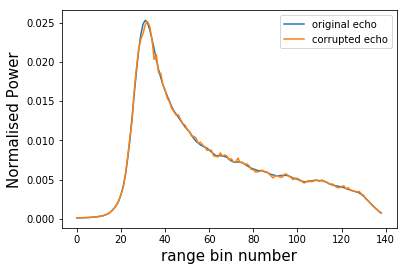

In [10]:
echo = feature_arr[1000] #extracting a random echo to plot
echo_mod = [np.random.normal(loc = echo[j], scale = echo[j]*0.025) for j in range(len(echo))]
plt.plot(echo, label = 'original echo')
plt.plot(echo_mod, label = 'corrupted echo')
plt.legend(loc = 'best')
plt.ylabel('Normalised Power', fontsize = 15)
plt.xlabel('range bin number', fontsize = 15)
plt.savefig("EchoCorruptionErr2.5.png", dpi = 200)

# The Lead Part (Including Lead SVC)

alphabetically:
$$D\_off = [0, 200, 400, 600, 800, 1000]; % distance off nadir (default = 0 m)$$
$$h\_s = [0, 0.05, 0.10, 0.15]; % snow depth, m$$
$$L\_ang = [0:10:90]; %lead angle from the across-track direction (between 0\u00B0 and 90\u00B0)$$
$$L\_w = [0:50:300]; % lead width (default = 100 m)$$

In [11]:
#Lead echo simulations (first part of three, corresponding to snow depths of 0 to 15cm):
LP1 = scipy.io.loadmat('/Users/claudederijkethomas/Desktop/Ice/Proj/FEM_Sim_LP1.mat')
#added arrays containing values of the parameters iterated over (to be used as SVC labels):
sim_params = LP1['parameters_lookup']
#simulated lead-containing waveforms:
sim_echoes = LP1['P_t_ml_range']

In [12]:
def extractL():
    """extracting (and preprocessing) the simulated echo arrays into a format that can be understood by the SVC."""
    counter = 0
    data_arr = []
    label_arr = []
    int_label_arr = []
    for i in range(len(sim_echoes[:][:][:][:])): #snow depth{s} (h_s)
        for j in range(len(sim_echoes[0][:][:][:])): #l_surf{s}
            for k in range(len(sim_echoes[0][0][:][:])): #sigma_si{s}
                for l in range(len(sim_echoes[0][0][0][:])): #sigma_surf{s}
                    simulated_echo = [sim_echoes[i][j][k][l][m][0] for m in range(len(sim_echoes[i][j][k][l]))]
                    sim_echo_params = [sim_params[i][j][k][l][0][m] for m in range(len(sim_params[i][j][k][l][0]))]
                    simulated_echo_area = trapz(simulated_echo, dx = 1) 
                    norm_sim_echo = [x/simulated_echo_area for x in simulated_echo]
                    data_arr.append(norm_sim_echo)
                    label_arr.append(str(sim_echo_params))
                    int_label_arr.append(counter)
                    counter+=1
    return np.array(data_arr), np.array(label_arr),np.array(int_label_arr)
feature_arr,label_arr,int_label_arr = extractL() #for features for both the SVC and neural network, labels for the SVC and for labels for the neural network

In [13]:
print(np.shape(feature_arr)) #for features for both the SVC and neural network
print(np.shape(label_arr)) #for labels for the SVC
label_arr = np.array(label_arr, dtype = 'str')
print(np.shape(int_label_arr)) #for labels for the neural network

(1680, 139)
(1680,)
(1680,)


In [14]:
clfL = SVC(gamma='auto') #creating the lead suppport vector classification
clfL.fit(feature_arr, label_arr) #training the lead SVC using the simulated echoes and their corresponding parameters

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [16]:
def proportion_correct_predictions():
    correct_counter = 0
    incorrect_counter = 0
    #removing the first 560 echoes (corresponding to D_off= 0m and 200m):
    for i in prange(280*2,np.shape(feature_arr)[0]):
        if i%10==0: #(evaluating every 10th echo to speed up compute time)
            #extracting an echo
            echo = feature_arr[i]
            # slightly modifying the echo (for subsequent denoising accuracy calculation)
            echo_mod = [np.random.normal(loc = echo[j], scale = echo[j]*0.025) for j in range(len(echo))]
            #checking if the modified echo is accurately predicted as the clean echo:
            if clfL.predict([echo])[0] == clfL.predict([echo_mod])[0]:
                #counting the number of modified echoes correctly denoised:
                correct_counter+=1
            else:
                #counting the number of modified echoes incorrectly denoised:
                incorrect_counter+=1
    #returning the proportion of correct predictions:
    return correct_counter/(incorrect_counter+correct_counter)
proportion_correct_predictions()

0.9017857142857143

# Evaluating Parameters of a CryoSat-2 Waveform

In [36]:
#Loading a CryoSat-2 echo from extracting_waveforms.ipynb file:
pickle_in = open("CryoSat2Waveform.pickle", 'rb')
obs_arr = pickle.load(pickle_in)
"""NON LEAD PREDICTION:"""
print("NON-LEAD PREDICTION: ",np.array(clfNL.predict([obs_arr])[0]))
print("""    And so the random CryoSat-2 echo is predicted to have a snow depth of 5cm, large-scale correlation length
    length of 8cm, a sea ice rms height of 0.0015m and a large-scale rms roughness height of 0.5m. This is promising
    as these values lie close to the default values when compared to the range in values of the parameters that 
    the SVC trained for, apart from sigma_surf, which lies on the edge of the parameter space. This has to be taken 
    with some speculation however, as it has been assumed that this echo doesnt contain a lead.""")
"""LEAD PREDICTION:"""
print("LEAD PREDICTION: ",np.array(clfL.predict([obs_arr])[0]))
print("""    And so the random CryoSat-2 echo is predicted to have a lead at a distance off-nadir of 1000m, at an angle
    of 40 degrees from the across-track direction, with a lead-width of 200m. The snow depth is predicted to be 15cm.""")

NON-LEAD PREDICTION:  [0.05, 8.0, 0.0015, 0.5]
    And so the random CryoSat-2 echo is predicted to have a snow depth of 5cm, large-scale correlation length
    length of 8cm, a sea ice rms height of 0.0015m and a large-scale rms roughness height of 0.5m. This is promising
    as these values lie close to the default values when compared to the range in values of the parameters that 
    the SVC trained for, apart from sigma_surf, which lies on the edge of the parameter space. This has to be taken 
    with some speculation however, as it has been assumed that this echo doesnt contain a lead.
LEAD PREDICTION:  [1000.0, 40.0, 200.0, 0.15]
    And so the random CryoSat-2 echo is predicted to have a lead at a distance off-nadir of 1000m, at an angle
    of 40 degrees from the across-track direction, with a lead-width of 200m. The snow depth is predicted to be 15cm


# The Neural Network (Failed)

In [38]:
one_hot_labels = to_categorical(int_label_arr)

In [ ]:
def create_model():
    model = Sequential()
    #adding 400 nodes to the shallow layer:
    model.add(Dense(400, input_dim=int(139), kernel_initializer='normal', activation='relu'))
#     model.add(Dropout(0.2))
    # Another hidden layer of 16 units
    model.add(Dense(16, kernel_initializer='normal', activation='relu'))
    #output layer
    model.add(Dense(3388, kernel_initializer='normal', activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
# Wrap our Keras model in an estimator compatible with scikit_learn
estimator = KerasClassifier(build_fn=create_model, epochs=30, verbose=0)
# Now we can use scikit_learn's cross_val_score to evaluate this model identically to the others
cv_scores = cross_val_score(estimator, feature_arr, one_hot_labels, cv=15) # cv = train test split (k-1: 1)
cv_scores.mean()

Taking another approach

In [39]:
clfNN = MLPClassifier(solver='adam', alpha=1e-2, hidden_layer_sizes=(400, 16), random_state=1)
clfNN.fit(feature_arr, one_hot_labels)

MLPClassifier(activation='relu', alpha=0.01, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(400, 16), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [42]:
print(np.max(np.array(clfNN.predict([feature_arr[1000]])[0])))

0
